<center>
<h1><b>Prompt Engineering </b>
<h1><b>Classification tasks : Sentiment Analysis </b>
</center>

# Objectives

- Present LLMs as an effective tool to tackle classification problems.
- Illustrate prompt engineering for sentiment analysis.
- Build and evaluate LLMs on broader classification tasks.


Prompt Engineering:
1. Prepare Data
2. Devise Prompts
3. Evaluate Prompts

## Imports

In [1]:
import openai
import json
import tiktoken
import session_info
import pandas as pd
import numpy as np
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

/Users/mohamedyoussfi/Documents/Generative AI/CREWAI/starter_template/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
session_info.show()

## API Keys 

## Large Language Models

## How to count Tokens

In [3]:
encoding = tiktoken.encoding_for_model("gpt-4-turbo")
system_message =""" 
Peform Sentiment analysis of the revview presented in the user message.
The result should be positive or negative. Do not justify your response
"""
print(encoding.encode(system_message))

[720, 10407, 630, 24248, 3904, 6492, 315, 279, 5891, 1068, 10666, 304, 279, 1217, 1984, 627, 791, 1121, 1288, 387, 6928, 477, 8389, 13, 3234, 539, 9541, 701, 2077, 198]


## Test OpenAI - GPT-4o

In [10]:
OPEN_AI_KEY = "...."
gpt4_llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=OPEN_AI_KEY)
system_message = """
Perform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: screen, keyboard, and mousepad.
For each review presented as input:
- Identify if there are any of the 3 aspects (screen, keyboard, mousepad) present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspectArrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]
"""
prompt = [
  {"role": "system", "content": system_message},
  {"role": "user", "content": """
 ```The screen is good. The keyboard is bad and the mousepad is quite```
       """}, 
  {"role": "assistant", "content": """
      {'category':['screen','keyboard','mousepad'],'polarity':['positive','negative','neutral’]}
      """},
  {"role": "user", "content": """
       ```I am impressed by the quality of the screen. disappointed with the keyboard, 
          but the mousepad is of very good quality```
       """}
]

response = gpt4_llm.invoke(prompt)
print(response.content)

```json
{
  "category": ["screen", "keyboard", "mousepad"],
  "polarity": ["positive", "negative", "positive"]
}
```


## Test OpenAI - GPT-4o - with Direct Requests

In [5]:
import base64
import requests

# OpenAI API Key
api_key = "...."

system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="I think that your services are very fine"
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

payload = {
     "model": "gpt-4o",
    "messages": [
        {
            "role":"system",
            "content":system_message
        },
        {
            "role" : "user",
            "content" : user_message_template.format(review=user_message)
        }
    ],
    "max_tokens": 300,
    "temperature":0
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json()['choices'][0]['message']['content'])

positive


## Test Groq - llama3-70b-8192

In [6]:
GROQ_API_KEY = "...."
groq_llm = ChatGroq(model_name="llama3-70b-8192", temperature=0,  api_key=GROQ_API_KEY)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="I think that your services are very fine"
zero_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = groq_llm.invoke(zero_shot_prompt)
print(response.content.replace("</s>",""))

positive


## Test Ollama (Local Machine)

In [7]:
llama_llm  = Ollama(model="mistral", temperature=0)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative'.
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="The look is bad"
few_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = llama_llm.invoke(few_shot_prompt)
print(response)

 negative


## Test Multi Model - Image Description - GPT-4

In [8]:
import base64
import requests

# OpenAI API Key
api_key = "..."

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "images/students.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

prompt_text = """
Donne moi une description de cette image. Le résultat sera au format json avec les champs suivants :
 - Description : Une description de l'image 
 - Nombre de personnes dans l'image
 - Nombre de filles
 - Nombre de garçon
""" 
payload = {
    #"model": "gpt-4-vision-preview",
     "model": "gpt-4o",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": prompt_text
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json()['choices'][0]['message']['content'])

```json
{
  "Description": "C'est une photo de groupe prise dans une salle de classe. De nombreuses personnes sont assises derrière des bureaux en rangs, souriant et regardant vers l'appareil photo. La salle est bien éclairée avec des plafonniers et de grandes fenêtres sur la droite. Un tableau et des rideaux sont présents à gauche de l'image.",
  "Nombre de personnes dans l'image": 78,
  "Nombre de filles": 17,
  "Nombre de garçon": 61
}
```


## Test Image Generation - DALL-E

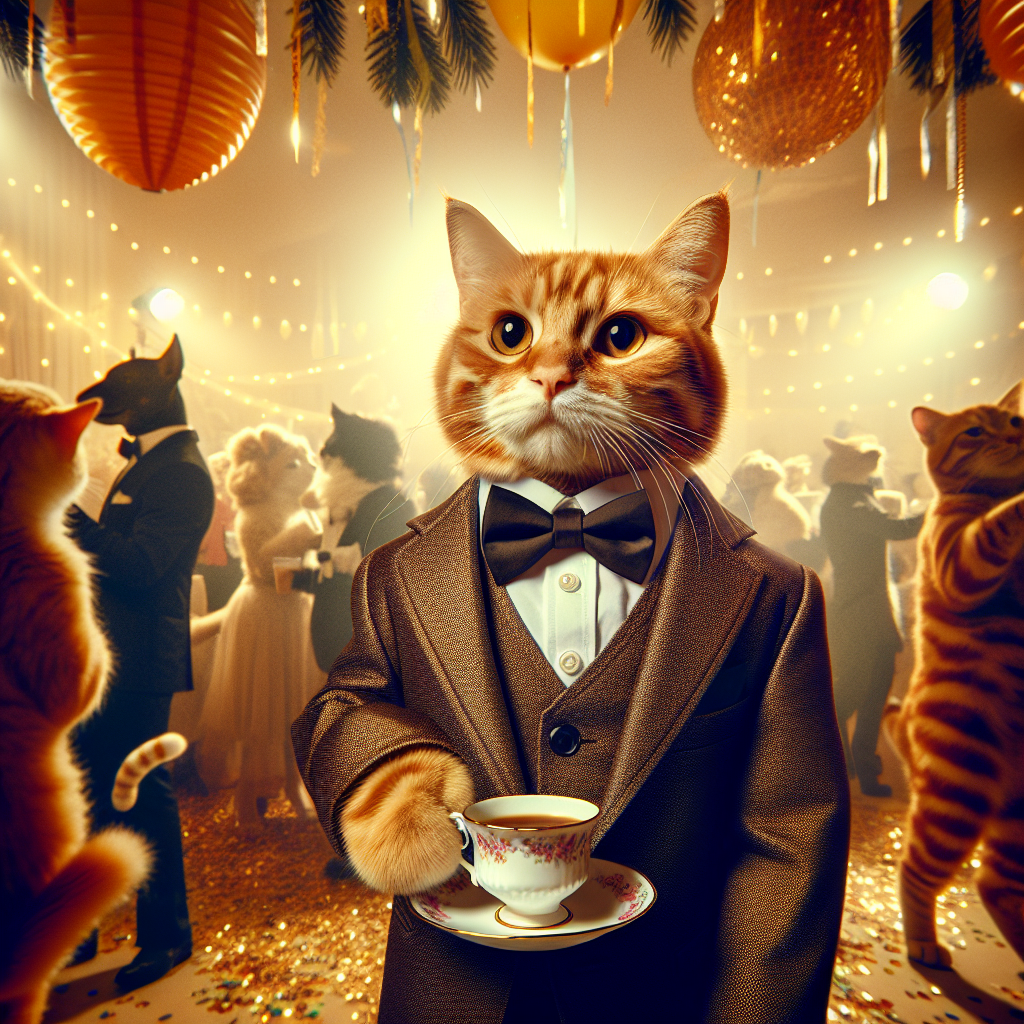

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x2956F0DF0>


In [9]:
import json
import requests
import io
import base64
from PIL import Image
from IPython.display import display

url = "https://api.openai.com/v1/images/generations"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

payload = {
    "model": "dall-e-3",
    "prompt": "un chat avec un costume dans une fête avec un café dans sa main",
    "response_format":"b64_json",
    "n": 1,
    "size":"1024x1024"
}

response = requests.post(url=f'{url}', headers=headers, json=payload)
image_data = response.json()["data"][0]["b64_json"]
image = Image.open(io.BytesIO(base64.b64decode(image_data)))
image.save('output.png')
display(image)
print(image)

b'{\n  "created": 1716371537,\n  "data": [\n    {\n      "b64_json": "iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAA552NhQlgAADnnanVtYgAAAB5qdW1kYzJwYQARABCAAACqADibcQNjMnBhAAAAOcFqdW1iAAAAR2p1bWRjMm1hABEAEIAAAKoAOJtxA3Vybjp1dWlkOjY4NGMzNDVmLWU0ZjQtNDY4ZC1hN2YxLTI2ZjIxOGE4ZTIxNwAAAAGhanVtYgAAAClqdW1kYzJhcwARABCAAACqADibcQNjMnBhLmFzc2VydGlvbnMAAAAAxWp1bWIAAAAmanVtZGNib3IAEQAQgAAAqgA4m3EDYzJwYS5hY3Rpb25zAAAAAJdjYm9yoWdhY3Rpb25zgaNmYWN0aW9ubGMycGEuY3JlYXRlZG1zb2Z0d2FyZUFnZW50Z0RBTEzCt0VxZGlnaXRhbFNvdXJjZVR5cGV4Rmh0dHA6Ly9jdi5pcHRjLm9yZy9uZXdzY29kZXMvZGlnaXRhbHNvdXJjZXR5cGUvdHJhaW5lZEFsZ29yaXRobWljTWVkaWEAAACranVtYgAAAChqdW1kY2JvcgARABCAAACqADibcQNjMnBhLmhhc2guZGF0YQAAAAB7Y2JvcqVqZXhjbHVzaW9uc4GiZXN0YXJ0GCFmbGVuZ3RoGTnzZG5hbWVuanVtYmYgbWFuaWZlc3RjYWxnZnNoYTI1NmRoYXNoWCBN/YJHtKWE9UyUvFzoD+olZiDLfb3BmCm/y24enzuRZGNwYWRIAAAAAAAAAAAAAAG4anVtYgAAACRqdW1kYzJjbAARABCAAACqADibcQNjMnBhLmNsYWltAAAAAYxjYm9yqGhkYzp0aXRsZWlpbWFnZS5wbmdpZGM6Zm9ybWF0Y3BuZ2ppbnN0YW5jZUlEeCx4bXA6aWlkOmY2NmFkMzRhLWE3YjgtNG

## Test Image Generation - LOcal Stable Diffusion

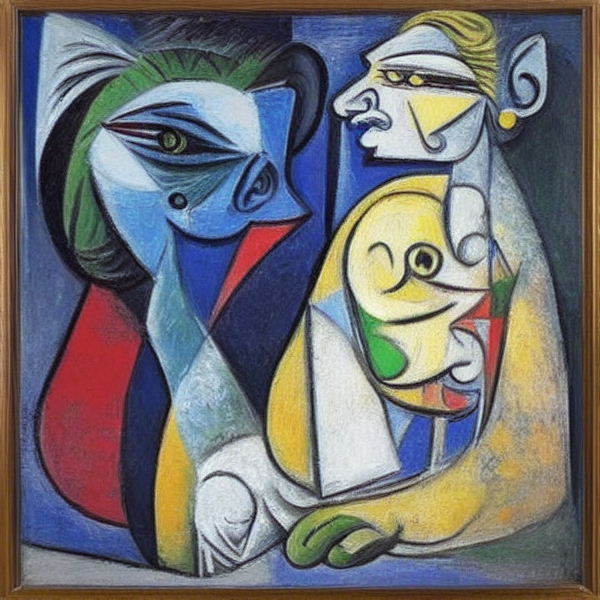

In [79]:
import json
import requests
import io
import base64
from PIL import Image
from IPython.display import display

url = "http://127.0.0.1:7860"

payload = {
    "prompt": "Une peinture de PICASSO représentant un chat",
    "steps": 50,
    "width":600,
    "height":600
}

response = requests.post(url=f'{url}/sdapi/v1/txt2img', json=payload)

r = response.json()

image = Image.open(io.BytesIO(base64.b64decode(r['images'][0])))
image.save('output2.png')
display(image)

### Step 1: Define objectives & metrics

In sentiment analysis, we assign one of two labels - positive or negative (in some cases one of three labels - positive, negative or neutral) to the text presented as input. As an example use case, we will assign sentiment to customer reviews for products listed in the apparel category on Amazon.

Since our prediction will be one of two labels - positive or negative - we could use the following metrics to measure the performance of a prompt.

- Accuracy score: calculated as the number of correct predictions (i.e., the number of times the prediction matches the ground truth)

- Micro-F1 score: calculated by computing the True Positives (TP), False Negatives (FN), and False Positives (FP) across all classes. This metric is used when we do not suspect class imbalance (for e.g., if we expect that there won't be an overwhelming amount of positive or negative reviews).

In practise, it is preferable to use a nuanced metric such as micro-F1 over plain accuracy.

To illustrate the computation of micro F1 score for a two-class scenario, we can use a confusion matrix. A confusion matrix is a table that shows the number of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) for a binary classification problem.

Here is an example of a confusion matrix for a two-class scenario:

| Predicted/Actual | Positive | Negative |
| ---------------- | -------- | -------- |
| Positive | 50 | 10 |
| Negative | 5 | 100 |

To compute the micro F1 score, we first calculate the total number of true positives, false positives, and false negatives across both classes:

- Total true positives = 50
- Total false positives = 10
- Total false negatives = 5

Then, we can calculate the precision, recall, and F1 score for the micro average:

- Micro-precision = Total true positives / (Total true positives + Total false positives) = 50 / (50 + 10) = 0.833
- Micro-recall = Total true positives / (Total true positives + Total false negatives) = 50 / (50 + 5) = 0.909
- Micro-F1 score = 2 * (Micro-precision * Micro-recall) / (Micro-precision + Micro-recall) = 2 * (0.833 * 0.909) / (0.833 + 0.909) = 0.870

Therefore, the micro F1 score for this example is 0.870.

We will use the `f1_score` implementation from `scikit-learn` to evaluate prompts for sentiment analysis in this notebook.

### Step 2: Assemble Data

For the sentiment analysis exercise, we will use a dataset of movie reviews [scraped from IMDB](https://huggingface.co/datasets/imdb). Our investigation will focus on assigning positive or negative sentiment to movie reviews that customers have posted on IMDB. During prompt engineering, we will use a hold-out set of reviews (i.e., gold examples) to ascertain the quality of the sentiment assignment.

In [80]:
corpus = load_dataset("imdb")

In [81]:
corpus

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Note that the dataset is already split into three subsets - train, test and unsupervised (i.e., without label). Machine learning datasets are usually stored this way; however, we do not intend to train a sentiment classifier from scratch, so we focus only on the training data.

When we assemble a dataset for LLM usage, we create splits for examples and gold examples and save these versions for future iterations. Let us see how this process is executed on the `train` subset of the data. To make data wrangling easier, let us convert the train to DataFrames.

In [82]:
train_df = corpus['train'].to_pandas()

In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [84]:
train_df.label.value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

Note how the dataset is evenly balanced with equal number of reviews assembled for positive (label 1) and negative sentiment (label 0).

In order to facilitate comparison of the ground truth labels with model predictions, let us add the corresponding text label as an additional column to the data.

In [85]:
train_df['sentiment'] = np.where(train_df.label == 1, "positive", "negative")

In [86]:
train_df.sample(6)

text  label sentiment
1867   Personally I think this show looks pretty chea...      0  negative
6994   Avoid this one, unless you want to watch an ex...      0  negative
16909  Well, if you are one of those Katana's film-nu...      1  positive
10730  I'd never seen a Tarzan movie before so when I...      0  negative
2173   Not that "a film by Ulli Lommel" filled me wit...      0  negative
1869   This is my first movie review on IMDb. I was f...      0  negative

We now have the dataset in the correct format to be parsed by LLM.

In [87]:
train_df.sentiment.value_counts()

sentiment
negative    12500
positive    12500
Name: count, dtype: int64

<Axes: >

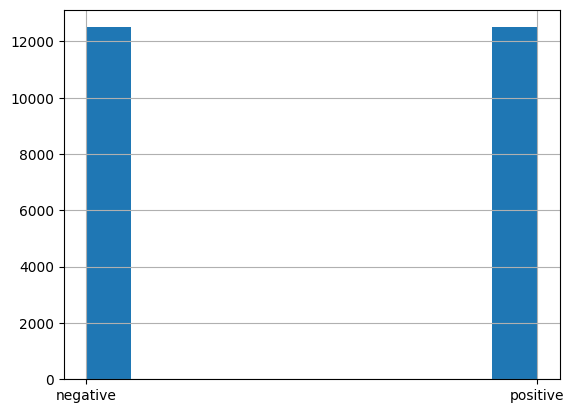

In [88]:
train_df.sentiment.hist()

Now that the preprocessing is done, let us split the data into two segments - one segment that gives us a pool to draw few-shot examples from and another segment that gives us a pool of gold examples.

In summary (see figure below), we extract a dataset from a corpus by processing required fields. Each example should contain the text input and an annotated label. Once we create examples and gold examples from this dataset, this curated dataset is stored in a format appropriate for reuse (e.g., JSON).

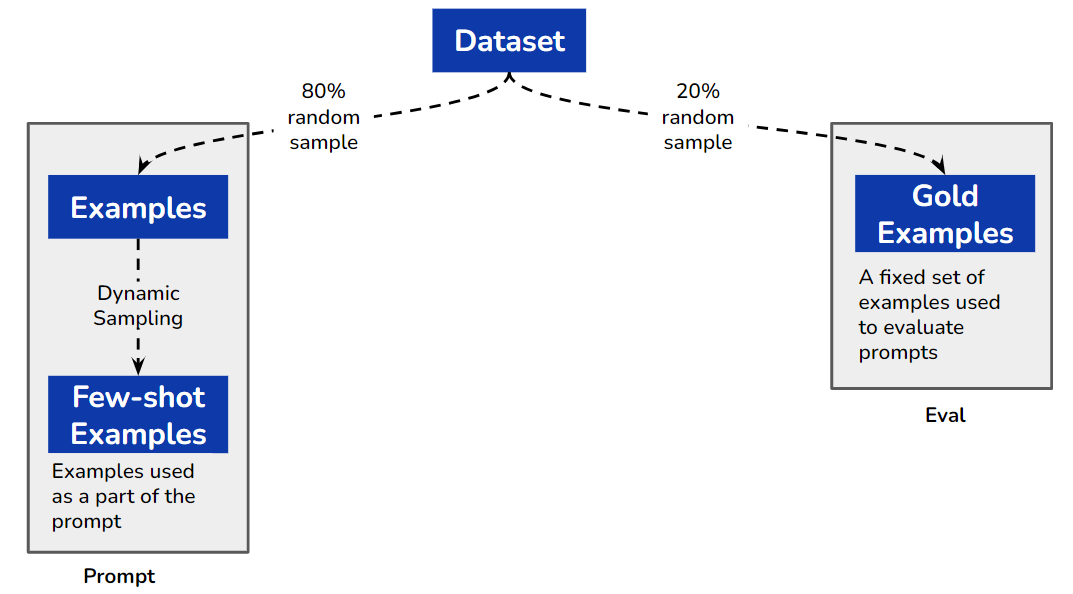

In [89]:
examples_df, gold_examples_df = train_test_split(
    train_df, test_size=0.2, random_state=42 
)

In [90]:
(examples_df.shape, gold_examples_df.shape)

((20000, 3), (5000, 3))

To select gold examples for this session, we sample randomly from the test data using a `random_state=42`. This ensures that the examples from multiple runs of the sampling are the same (i.e., they are randomly selected but do not change between different runs of the notebook). Note that we are doing this only to keep execution times low for illustration. In practise, large number of gold examples facilitate robust estimates of model accuracy.

In [91]:
columns= ['text', 'sentiment']
gold_examples = ( gold_examples_df.loc[:, columns].sample(20, random_state=42).to_json(orient='records'))

In [92]:
json.loads(gold_examples)[0]

{'text': 'Like I said at the top, four stars just aren\'t enough. It\'s one of the best films I\'ve ever seen in my almost 17 years of life. For the people that don\'t really like it or understand it, you must not have a real appreciation for art or you might have a short attention span.<br /><br />Even if I haven\'t seen all his films yet, I\'d have to say that this is Spielberg at his peak. It\'s pretty sad to see that movies as great as "The Color Purple" don\'t come along too often \'cause I think all of us are in desperate need of first-class motion picture entertainment in these hard times.<br /><br />Movies like this are more than just movies; they\'re pieces of art that need to be appreciated more.<br /><br />The idea that it was nominated for 11 Oscars (even Best Picture of the Year) and didn\'t get one trophy is a sign of how blind and stupid Hollywood can be sometimes. Spielberg wasn\'t even nominated for Best Director! It should have swept the Oscars that year.<br /><br />T

### Step 3: Derive Prompt

#### Create prompts

In [93]:
user_message_template = """```{movie_review}```"""

**Prompt 1: Zero-shot**

In [94]:
zero_shot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""

In [95]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

**Prompt 2: Few-shot**

For the few-shot prompt, there is no change in the system message compared with the zero-shot prompt. However, we augment this system message with few shot examples.  

In [96]:
few_shot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks in the input.
Answer only 'positive' or 'negative'
Do not explain your answer.
"""

To assemble few-shot examples, we will need to sample the required number of reviews from the training data. One approach would be to  first subset positive and negative reviews and then select samples from these subsets like so (note how we assemble 8 few-shot examples in the code below):

In [97]:
positive_reviews = (examples_df.sentiment == 'positive')
negative_reviews = (examples_df.sentiment == 'negative')

In [98]:
(positive_reviews.shape, negative_reviews.shape)

((20000,), (20000,))

In [99]:
columns = ['text', 'sentiment']
positive_examples = examples_df.loc[positive_reviews, columns].sample(4)
negative_examples = examples_df.loc[negative_reviews, columns].sample(4)

In [100]:
positive_examples

text sentiment
13256  ** possible spoilers **<br /><br />I like this...  positive
14607  Has there ever been a movie more charming than...  positive
21876  Before watching this film I had heard a lot ab...  positive
13738  The memory of the "The Last Hunt" has stuck wi...  positive

In [101]:
negative_examples

text sentiment
2057  Contains spoilers. <br /><br />The British dir...  negative
6158  SPOILERS. Strange people with generous tastes ...  negative
8177  The world is facing imminent destruction and a...  negative
3116  Great movie - especially the music - Etta Jame...  negative

However, merely selecting random samples from the polarity subsets is not enough because the examples included in a prompt are prone to a set of known biases such as:
 - Majority label bias (frequent answers in predictions)
 - Recency bias (examples near the end of the prompt)


To avoid these biases, it is important to have a balanced set of examples that are arranged in random order. Let us create a Python function that generates bias-free examples (our function implements the workflow presented below):

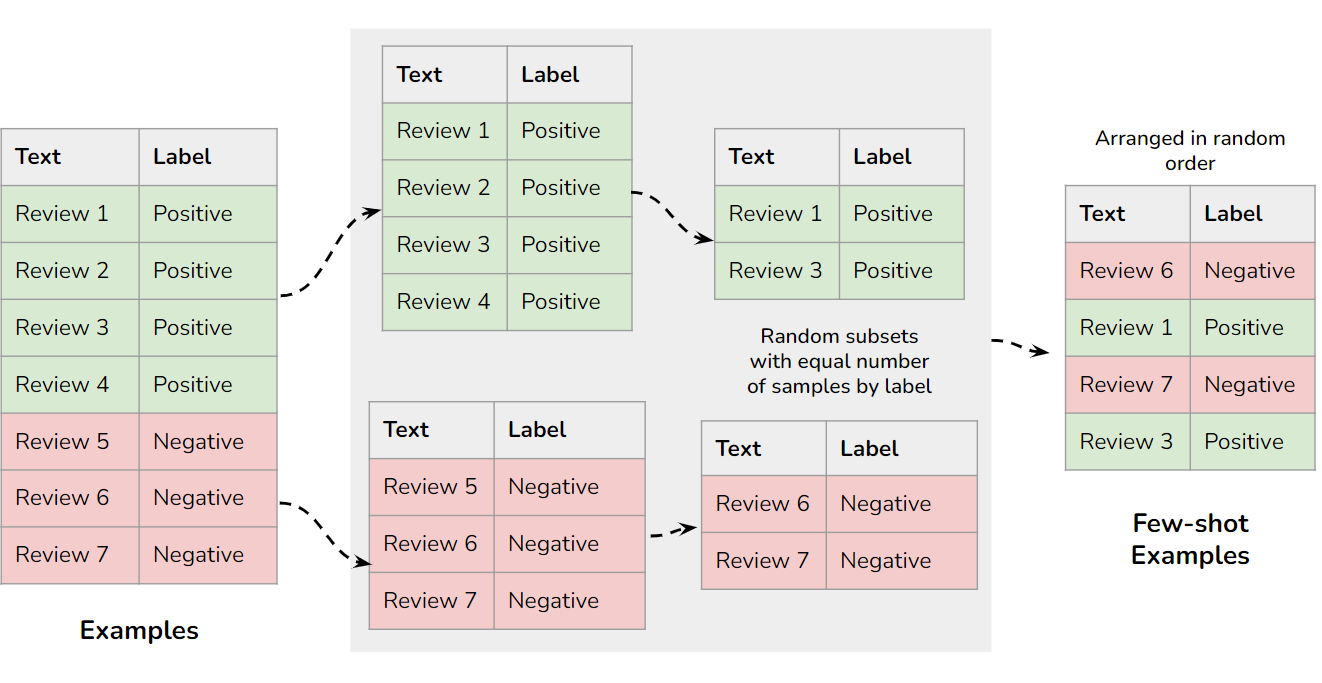

In [102]:
def create_examples(dataset, n=4):
    positive_reviews = (dataset.sentiment == 'positive')
    negative_reviews = (dataset.sentiment == 'negative')
    columns_to_select = ['text', 'sentiment']
    positive_examples = dataset.loc[positive_reviews, columns_to_select].sample(n)
    negative_examples = dataset.loc[negative_reviews, columns_to_select].sample(n)
    examples = pd.concat([positive_examples, negative_examples])
    # sampling without replacement is equivalent to random shuffling
    randomized_examples = examples.sample(2*n, replace=False)
    return randomized_examples.to_json(orient='records')

In [103]:
examples = create_examples(examples_df, 2)

In [104]:
json.loads(examples)

[{'text': "Well, AWFUL is just the first name. This movie is a cliché-ridden piece of junk. A high school comedy setup in a military training camp. I'm sorry I had to give this 1 star which it did not deserve.<br /><br />THIS MAY CONTAIN SPOILERS:<br /><br />Just about everything is totally forced, unconvincing and unrealistic. The HEPO (military police) will not come to get you if you don't make your appearance, especially not on your wedding day. The actors were pretty embarrassed during this scene, because the scene didn't work as it was so highly unlikely. You can sense it in their voices. Even if they were not such bad actors, they wouldn't have been able to save the scene. <br /><br />Next the guy has to exercise in his wedding suit. No, there was no time to get him an uniform first. Man, this is great cinematography! I will remember this scene for the rest of my life.<br /><br />There are also GIRLS in the camp--exciting--one of'em even a model, though not looking that great--an

With the examples in place, we can now assemble a few-shot prompt. Since we will be using the few-shot prompt several times during evaluation, let us write a function to create a few-shot prompt (the logic of this function is depicted below).

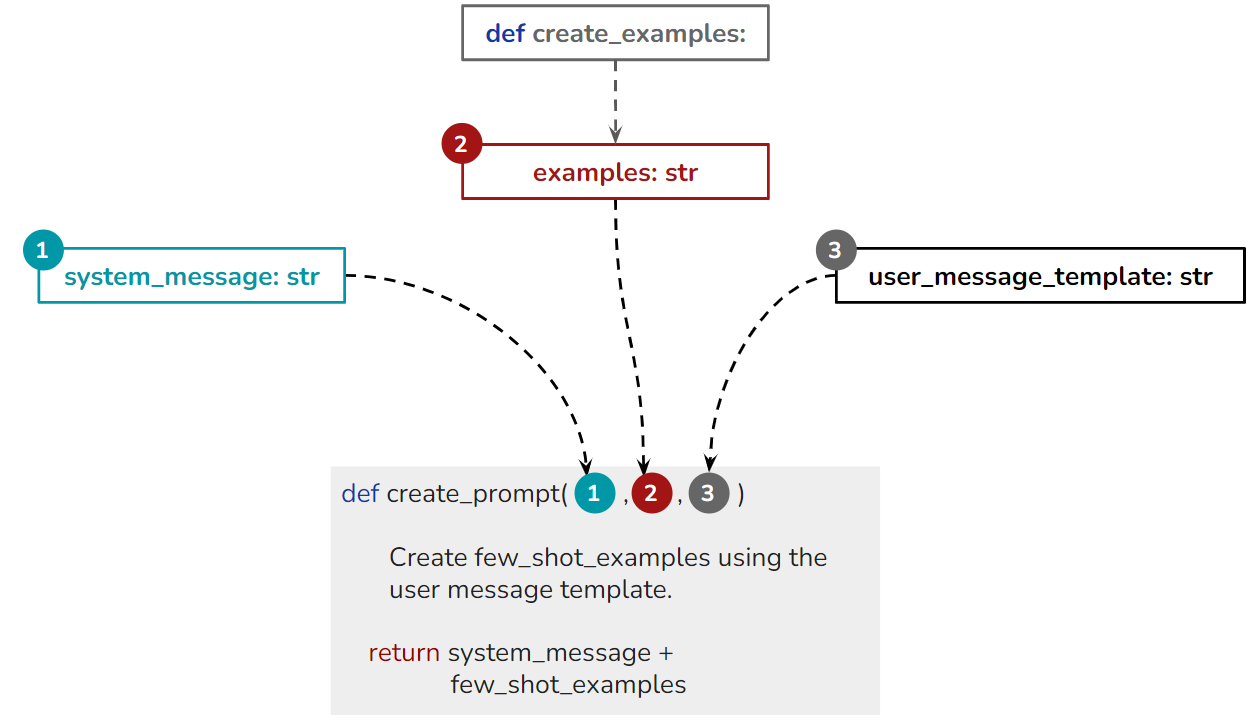

In [105]:
def create_prompt(system_message, examples, user_message_template):
    few_shot_prompt = [{'role':'system', 'content': system_message}]
    for example in json.loads(examples):
        example_review = example['text']
        example_sentiment = example['sentiment']
        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    movie_review=example_review
                )
            }
        )
        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example_sentiment}"}
        )
    return few_shot_prompt

In [106]:
few_shot_prompt = create_prompt(
    few_shot_system_message,
    examples,
    user_message_template
)

In [107]:
few_shot_prompt

[{'role': 'system',
  'content': "\nClassify the sentiment of movie reviews presented in the input as 'positive' or 'negative'\nMovie reviews will be delimited by triple backticks in the input.\nAnswer only 'positive' or 'negative'\nDo not explain your answer.\n"},
 {'role': 'user',
  'content': "```Well, AWFUL is just the first name. This movie is a cliché-ridden piece of junk. A high school comedy setup in a military training camp. I'm sorry I had to give this 1 star which it did not deserve.<br /><br />THIS MAY CONTAIN SPOILERS:<br /><br />Just about everything is totally forced, unconvincing and unrealistic. The HEPO (military police) will not come to get you if you don't make your appearance, especially not on your wedding day. The actors were pretty embarrassed during this scene, because the scene didn't work as it was so highly unlikely. You can sense it in their voices. Even if they were not such bad actors, they wouldn't have been able to save the scene. <br /><br />Next the g

**Prompt 3: Chain-of-Thought**

For the CoT prompt, we add detailed step-by-step instructions to the few shot system message instructing the model to carefully ponder before assigning sentiment. Apart from this addition, there are no further changes from the few-shot prompt.

In [108]:
cot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.

Instructions:
1. Carefully read the text of the review and think through the options for sentiment provided
2. Consider the overall sentiment of the review and estimate the probability of the review being positive

To reiterate, your answer should strictly only contain the label: positive or negative
"""

In [109]:
cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

In [110]:
cot_few_shot_prompt

[{'role': 'system',
  'content': "\nClassify the sentiment of movie reviews presented in the input as 'positive' or 'negative'\nMovie reviews will be delimited by triple backticks ``` in the input.\nAnswer only 'positive' or 'negative' \nDo not explain your answer.\n\nInstructions:\n1. Carefully read the text of the review and think through the options for sentiment provided\n2. Consider the overall sentiment of the review and estimate the probability of the review being positive\n\nTo reiterate, your answer should strictly only contain the label: positive or negative\n"},
 {'role': 'user',
  'content': "```Well, AWFUL is just the first name. This movie is a cliché-ridden piece of junk. A high school comedy setup in a military training camp. I'm sorry I had to give this 1 star which it did not deserve.<br /><br />THIS MAY CONTAIN SPOILERS:<br /><br />Just about everything is totally forced, unconvincing and unrealistic. The HEPO (military police) will not come to get you if you don't m

Note that the examples remain the same while the system message changes.

#### Evaluate prompts

Now we have three sets of prompts that we need to evaluate using gold labels. Since the few-shot prompt and the CoT prompt depend on the sample of examples that was drawn to make up the prompt, we expect some variability in evaluation. Hence, we evaluate each prompt multiple times to get a sense of the average and the variation around the average.

To reiterate, a choice on the prompt should account for variability due to the choice of the random sample. To aid repeated evaluation, we assemble an evaluation function (overall logic depicted in the figure below).

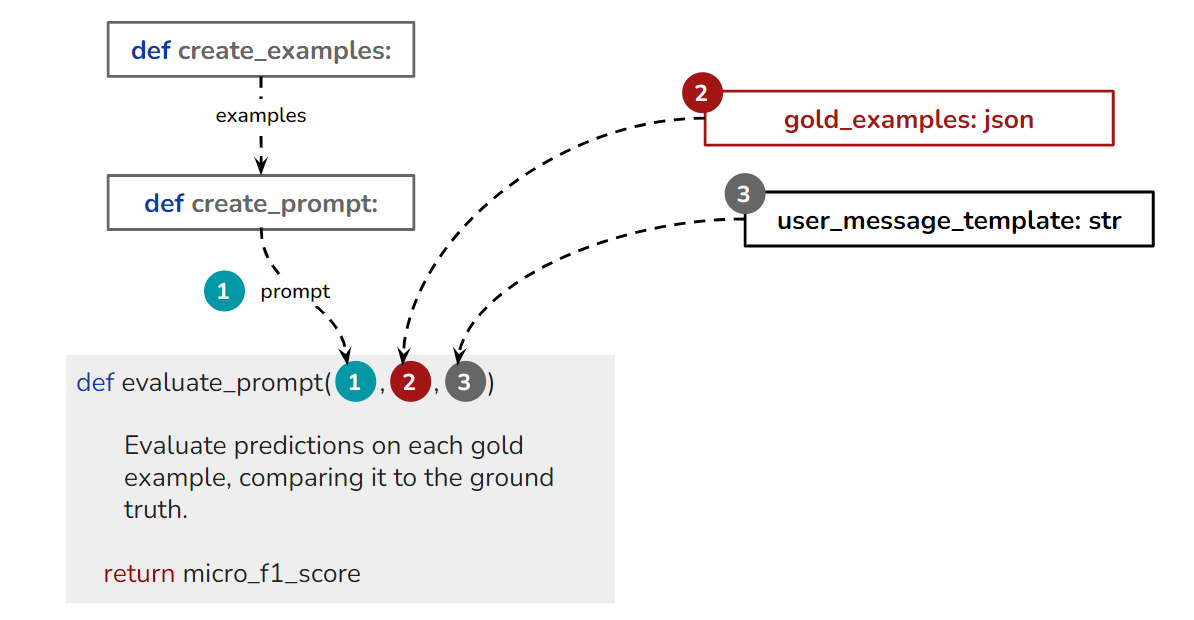

In [113]:
def evaluate_prompt(prompt, gold_examples, user_message_template, model):
    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_input = example['text']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(movie_review=gold_input)
            }
        ]

        try:
            response = model.invoke(
               prompt+user_input
            )
            if hasattr (response, 'content'):
                response_content = response.content
            else:
                response_content = response    
            if 'negative' in response_content.strip().lower():
                prediction='negative'
            elif 'positive' in response_content.strip().lower():
                prediction='positive'
            else:
                prediction ='unknown'
            model_predictions.append(prediction)
            ground_truths.append(example['sentiment'])
            #print(prediction, example['sentiment'])

        except Exception as e:
            print(e)
            continue

    micro_f1_score = f1_score(ground_truths, model_predictions, average="micro")

    return micro_f1_score

Let us now use this function to do one evaluation of all the three prompts assembled so far, each time computing the Micro-F1 score.

In [117]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template, gpt4_llm)

1.0

In [118]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template, gpt4_llm)

1.0

In [119]:
evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template, gpt4_llm)

1.0

However, this is just *one* choice of examples. We will need to run these evaluations with multiple choices of examples to get a sense of variability in F1 score for the few-shot prompt and the CoT prompt. As an example, let us run evaluations for the few-shot prompt and the CoT prompt 10 times.

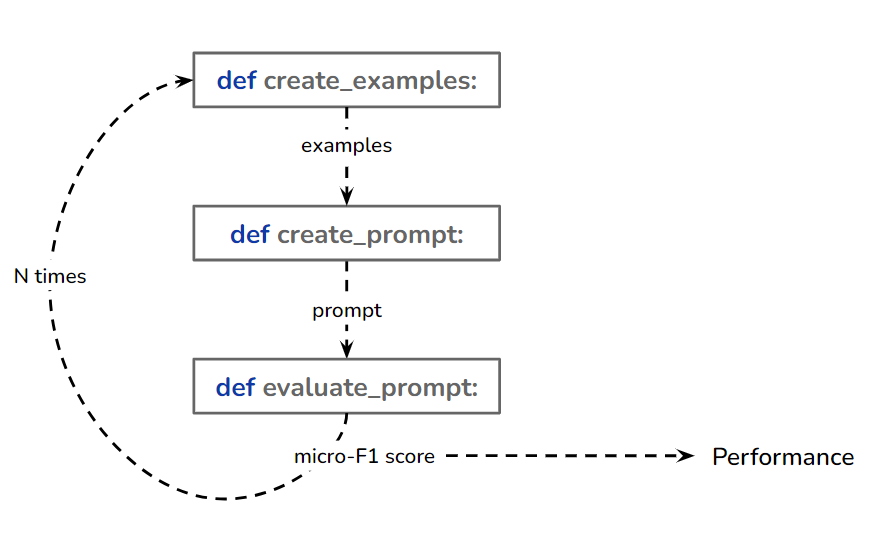

In [120]:
num_eval_runs = 10

In [121]:
few_shot_performance, cot_few_shot_performance = [], []

In [122]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(examples_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)
    #cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_micro_f1 = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template, gpt4_llm)
    #cot_few_shot_micro_f1 = evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_micro_f1)
    cot_few_shot_performance.append(few_shot_micro_f1)

100%|██████████| 10/10 [02:46<00:00, 16.65s/it]


In [123]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(1.0, 0.0)